In [1]:
import tensorflow as tf
from tensorflow import keras as keras
from keras import layers as layers
import os, timeit
from skimage.filters import threshold_otsu
import numpy as np
from math import inf as inf
import pandas as pd
import sys

2023-08-02 15:42:55.811328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 15:42:56.793189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
from sys import platform
DATA_DIRECTORY = ""
SLASH = ""
if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "/home/tyagi/Desktop/wheat/data/BULK/"
    SLASH = "/"
elif platform == "win32":
    DATA_DIRECTORY = "D:\mvl\wheat\data\BULK\\"
    SLASH="\\"

In [5]:
#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.9
TOTAL_IMAGE_COUNT = 2400
IMAGE_COUNT = int(TOTAL_IMAGE_COUNT/4)
NUM_VARIETIES = 4

IMAGE_WIDTH = 30
IMAGE_HEIGHT = 30

In [6]:
ACTIVATION_TYPE =  "relu"
BATCH_SIZE = 2*NUM_VARIETIES

LEARNING_RATE_BASE = 0.0001

In [7]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3
    
FILTER = filter_method(1).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = "none"

In [8]:
from enum import Enum
 
class feature_extraction_method(Enum):
    none = 0
    pca_loading = 1
    lda = 2
    ipca = 3

FEATURE_EXTRACTION = feature_extraction_method(0).name

NUM_OF_BANDS = 3
if FEATURE_EXTRACTION == "pca_loading" or FEATURE_EXTRACTION == "ipca":
    NUM_OF_BANDS = 8
elif FEATURE_EXTRACTION == "lda":
    NUM_OF_BANDS = 3
    assert NUM_OF_BANDS <= min(NUM_VARIETIES-1,168),"NUM_OF_BANDS is greater."


REMOVE_NOISY_BANDS = False
FIRST_BAND = 15
LAST_BAND = 161

In [9]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [10]:
def dataset_file_name(variety):
    name = "./dataset/V"+str(variety).zfill(3)+"_IC_"+str(TOTAL_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
    if REMOVE_NOISY_BANDS:
        name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)
    return name

In [11]:
test_dataset=[]
test_dataset_label = []

for idx, v in enumerate(VARIETIES):
    print("idx: ",idx)
    if idx >= NUM_VARIETIES:
        break
    test_dataset = test_dataset + np.load(dataset_file_name(v)+"_test_dataset.npy").tolist()
    test_dataset_label = test_dataset_label + np.load(dataset_file_name(v)+"_test_dataset_label.npy").tolist()
    
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(test_dataset_label)

idx:  0
idx:  1
idx:  2
idx:  3


In [12]:
start_epoch = 2271

In [13]:
model_name = "GN_"+"_IC_"+str(TOTAL_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
if REMOVE_NOISY_BANDS:
    model_name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)
if FILTER == "savgol":
    model_name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)

if start_epoch != 1:
    model = tf.keras.models.load_model('./GNmodels/'+str(start_epoch-1)+model_name)

2023-08-02 15:43:47.519195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21767 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:9b:00.0, compute capability: 8.6


In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

2023-08-02 15:43:57.873098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


 3/60 [>.............................] - ETA: 2s  

2023-08-02 15:44:00.843031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


60/60 [==============================] - 10s 53ms/step


In [15]:
y_pred_labels = np.argmax(y_pred, axis=2)

In [16]:
for y_pred_label in y_pred_labels:
    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)
    
    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))

Accuracy: 0.9166666666666666
Confusion Matrix:
[[435  24   7  14]
 [ 28 421   3  28]
 [  4   2 471   3]
 [ 15  27   5 433]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       480
           1       0.89      0.88      0.88       480
           2       0.97      0.98      0.98       480
           3       0.91      0.90      0.90       480

    accuracy                           0.92      1920
   macro avg       0.92      0.92      0.92      1920
weighted avg       0.92      0.92      0.92      1920

Accuracy: 0.8348958333333333
Confusion Matrix:
[[368  55  23  34]
 [ 67 382   2  29]
 [ 18   1 452   9]
 [ 38  37   4 401]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       480
           1       0.80      0.80      0.80       480
           2       0.94      0.94      0.94       480
           3       0.85      0.84      0.84       480


In [22]:
import seaborn as sn
import matplotlib.pyplot as plt

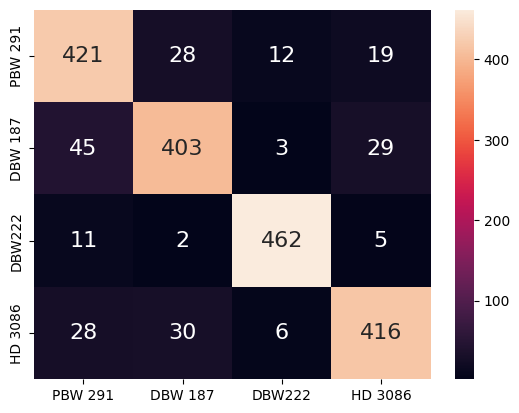

In [23]:
df_cm = pd.DataFrame(cm,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

plt.show()